### _Activity feature extractor_
Author : @leopauly | cnlp@leeds.ac.uk <br>
Description : Custom build network for extracting action features from a video

In [1]:
## Imports
import numpy as np
import cv2
import os
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten, MaxPooling2D, Input, Concatenate
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
import numpy as np
import pylab as plt
import keras
import keras.backend as K

## Custom scripts
import lscript as lsp
import dataset as dset

Using TensorFlow backend.


In [2]:
## Defining variables
time_step=50 # Number of frames to be skipped
imagefolderpath= ('/nobackup/leopauly/KTH_new/') # Folder pathe where the video sequences are stored
print(os.path.isdir(imagefolderpath)) # Checking if directory of video dataset exists
LOG_DIR='./logdir'
custom_global_step=0
hidden_num = 24 # Number of neurons in hidden layer of LSTM
nb_classes=3
lr_rate=.0005
batch_size = 20
nb_seq_train=360
no_of_batches = int(nb_seq_train / batch_size)
epoch = 5
height=150
width=300
channel=1

True


#### Loading and displaying data

label:0.0
Video_seq shape: (20, 50, 150, 300) Label shape (20,)


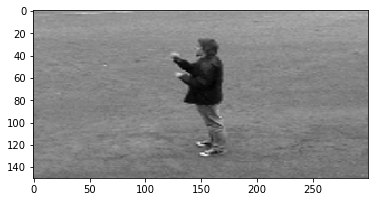

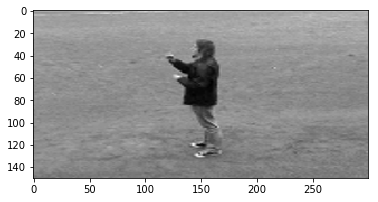

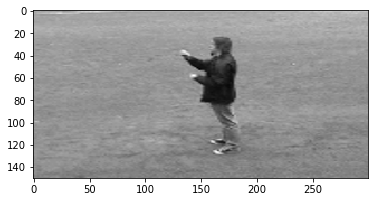

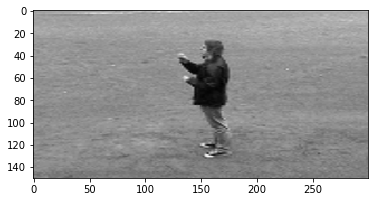

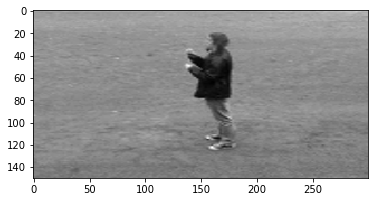

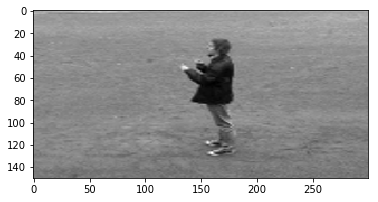

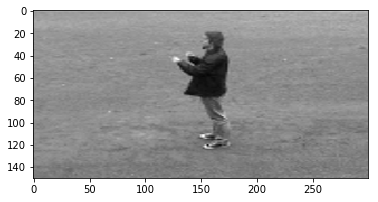

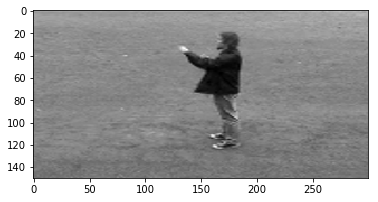

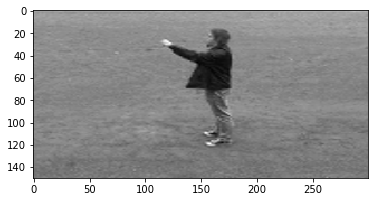

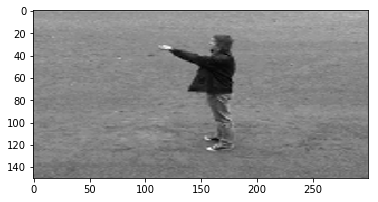

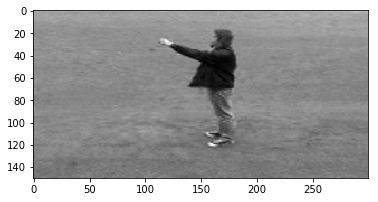

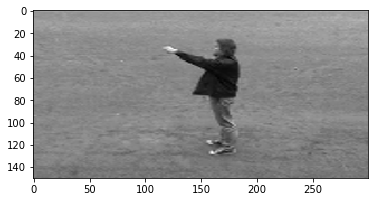

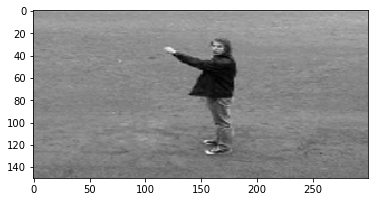

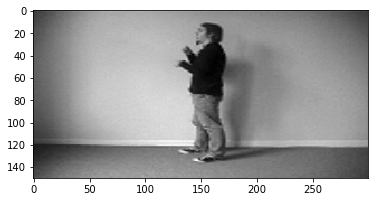

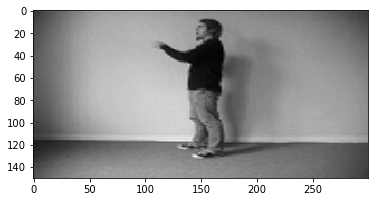

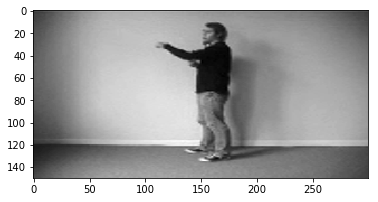

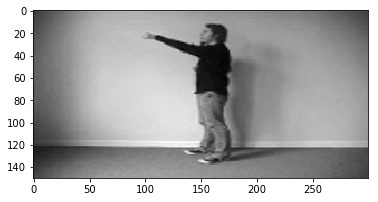

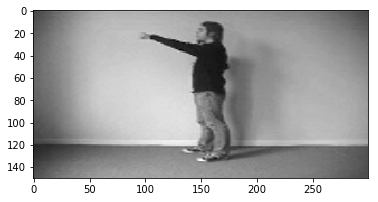

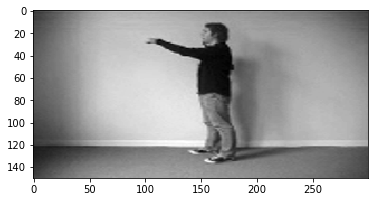

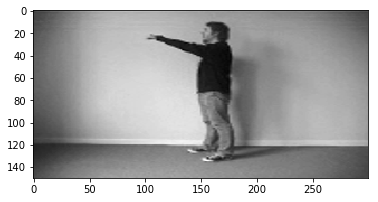

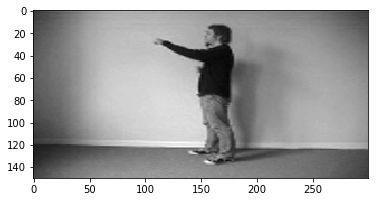

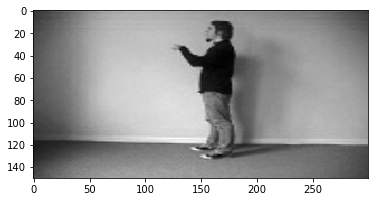

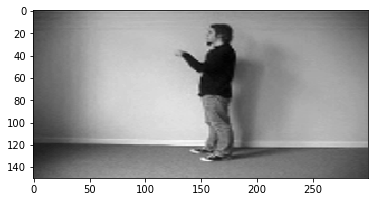

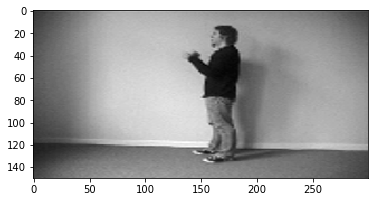

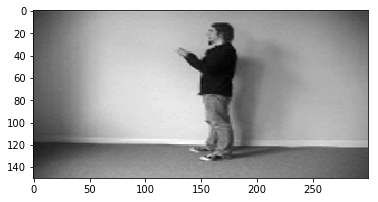

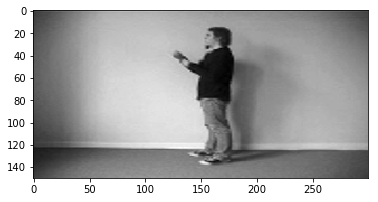

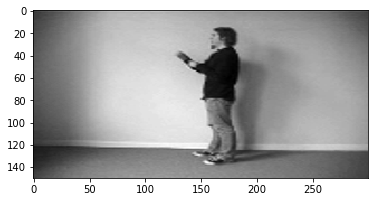

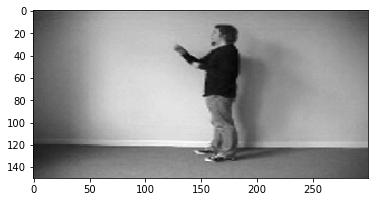

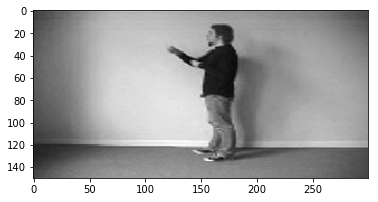

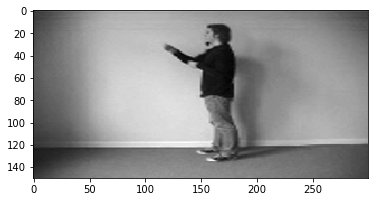

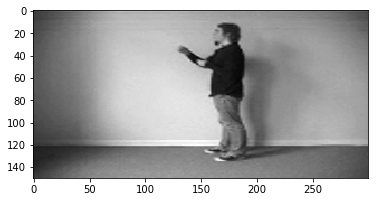

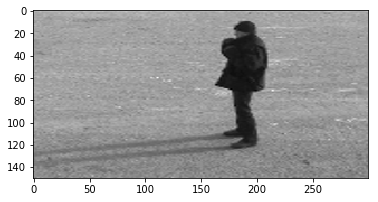

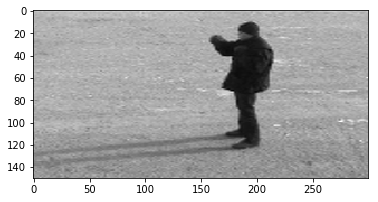

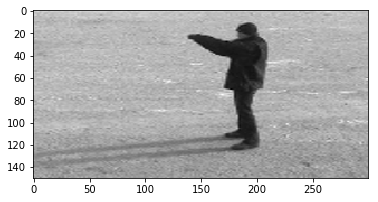

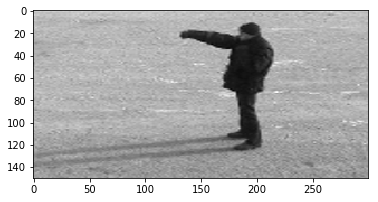

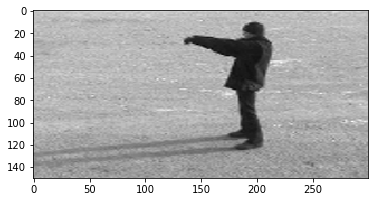

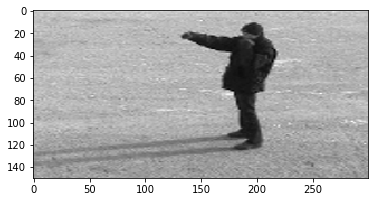

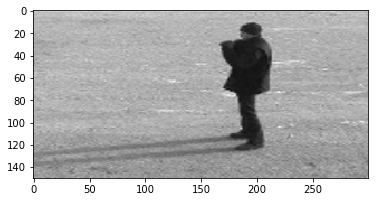

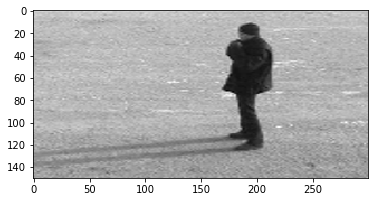

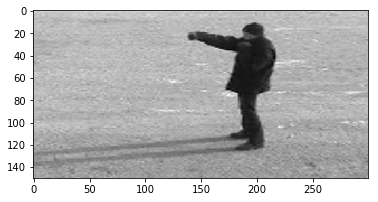

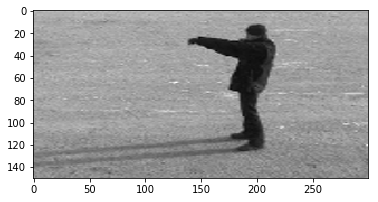

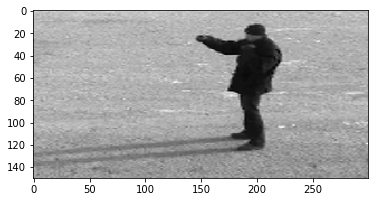

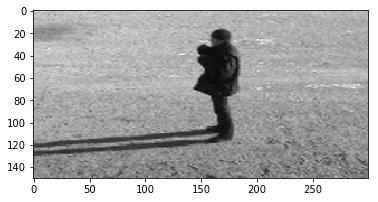

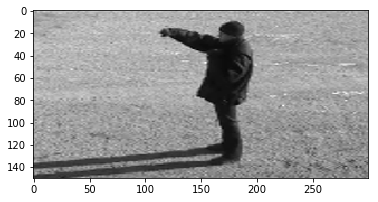

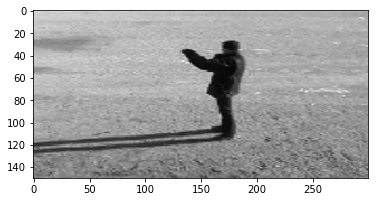

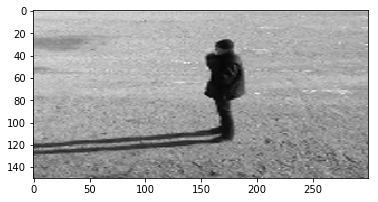

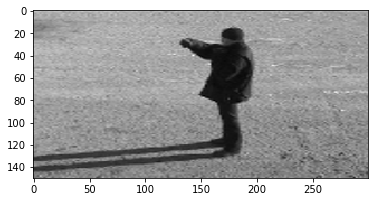

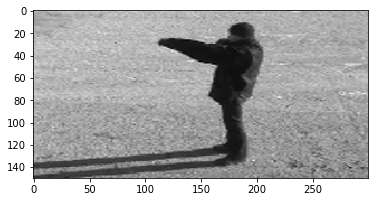

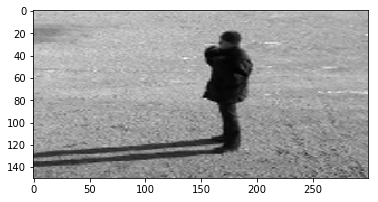

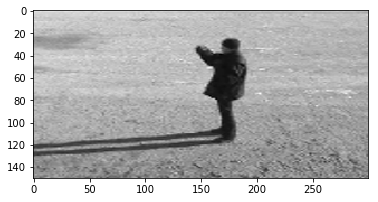

In [3]:
# TODO: Make display like an animation
x,y=dset.batch_gen_train(nb_classes,batch_size,time_step,height,width,channel,imagefolderpath,gray=True)
item_num=19
lsp.view_video_seq(x,y,time_step,item_num)

#### Defining model

In [4]:
## Defining placeholders in tf
data_1 = tf.placeholder(tf.float32, [None, time_step, height, width, channel]) #step_size=No: of frames in video sequence
data_2 = tf.placeholder(tf.float32, [None, time_step, height, width, channel])
data_3 = tf.placeholder(tf.float32, [None, time_step, height, width, channel])
target = tf.placeholder(tf.float32, [None, nb_classes])

In [5]:
## Suggested Network structure 1: Conv3D followed by ConvLSTM
input_1 = Input(shape=(3, height, width, channel))
input_2 = Input(shape=(3, height, width, channel))
input_3 = Input(shape=(3, height, width, channel))

conv3D=Conv3D(filters=1, kernel_size=(3,3,0),padding='same')
layer1_1=conv3D(inputs=input_1)
layer1_2=conv3D(inputs=input_2)
layer1_3=conv3D(inputs=input_3)

concatenated = keras.layers.concatenate([layer1_1, layer1_2,layer1_3],1)
model_out=ConvLSTM2D(filters=1, kernel_size=(5, 5),padding='SAME', return_sequences=True)(concatenated)

model=Model([input_1,input_2,input_3],model_out)
inter_out=model([data_1,data_2,data_3])
print(model.summary())

layer2=tf.nn.max_pool3d(inter_out,ksize=(1,1,4,4,1),strides=(1,1,4,4,1),padding='VALID')
size1=tf.shape(layer2)
shape1=tf.shape(layer2)
fc = tf.reshape(layer2,[batch_size, 133200]) #shape1[1]*shape1[2]*shape1[3]*shape1[4]])  #138750
#shape2=tf.shape(fc)
out=tf.layers.dense(fc,nb_classes)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 3, 150, 300, 1 0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 3, 150, 300, 1 0                                            
____________________________________________________________________________________________________
input_3 (InputLayer)             (None, 3, 150, 300, 1 0                                            
____________________________________________________________________________________________________
conv3d_1 (Conv3D)                (None, 3, 150, 300, 1 1           input_1[0][0]                    
                                                                   input_2[0][0]           

In [ ]:
## Suggested Network structure 2: Conv3D followed by LSTM
input_1 = Input(shape=(3, height, width, channel))
input_2 = Input(shape=(3, height, width, channel))
input_3 = Input(shape=(3, height, width, channel))

conv3D=Conv3D(filters=1, kernel_size=(3,3,0),padding='same')
layer1_1=conv3D(inputs=input_1)
layer1_2=conv3D(inputs=input_2)
layer1_3=conv3D(inputs=input_3)

concat= keras.layers.concatenate([layer1_1, layer1_2,layer1_3],1)
layer_2a = Conv3D(filters=1, kernel_size=(3,3,0),padding='same')
layer_2b = MaxPooling3D(pool_size=(2, 2, 2),strides=(2, 2, 2),border_mode='valid')(layer_2b)
layer_2c = Conv3D(filters=1, kernel_size=(3,3,0),padding='same')(layer_2b)

model_out=LSTM(10,return_sequences=True)(concatenated)

model=Model([input_1,input_2,input_3],model_out)
inter_out=model([data_1,data_2,data_3])
print(model.summary())

layer3=tf.nn.max_pool3d(inter_out,ksize=(1,1,4,4,1),strides=(1,1,4,4,1),padding='VALID')
size1=tf.shape(layer3)
shape1=tf.shape(layer3)
fc = tf.reshape(layer2,[batch_size, 133200]) #shape1[1]*shape1[2]*shape1[3]*shape1[4]])  #138750
#shape2=tf.shape(fc)
out=tf.layers.dense(fc,nb_classes)

In [6]:
init_op = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init_op)

x,y=dset.batch_gen_train(nb_classes,batch_size,time_step,height,width,channel,imagefolderpath,gray=True)
x =x.reshape(x.shape[0],x.shape[1],height,width,channel)
y_onehot = lsp.one_hot(y,nb_classes)
print(sess.run([size1,out],{data_1: x,data_2:x,data_2:x, target: y_onehot}))

InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder_2' with dtype float
	 [[Node: Placeholder_2 = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/gpu:0"]()]]

Caused by op 'Placeholder_2', defined at:
  File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/opt/conda/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-6e3d67d676c2>", line 4, in <module>
    data_3 = tf.placeholder(tf.float32, [None, time_step, height, width, channel])
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1507, in placeholder
    name=name)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1997, in _placeholder
    name=name)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'Placeholder_2' with dtype float
	 [[Node: Placeholder_2 = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/gpu:0"]()]]


In [ ]:
predictions= tf.nn.softmax(out)
cross_entropy=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=target,logits=out))
optimizer = tf.train.AdamOptimizer(lr_rate)
minimize = optimizer.minimize(cross_entropy)
mistakes = tf.not_equal(tf.argmax(target, 1), tf.argmax(predictions, 1))
error = tf.reduce_mean(tf.cast(mistakes, tf.float32))

# Defining variables for writing summary
tf.summary.histogram("predictions",predictions )
tf.summary.scalar("cross_entropy",cross_entropy )
summary_op = tf.summary.merge_all()

#### Training model

In [ ]:
#TODO : make data generater to generate class also
init_op = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init_op)

saver = tf.train.Saver()
train_writer = tf.summary.FileWriter('./logdir', sess.graph)

for i in range(epoch):
    ptr = 0
    for iteration in range(no_of_batches):
        #x=dset.batch_gen(0+(batch_size*iteration),batch_size+(batch_size*iteration),batch_size,time_step,height,width,channel,imagefolderpath,gray=True)
        x,y=dset.batch_gen_train(nb_classes,batch_size,time_step,height,width,channel,imagefolderpath,gray=True)
        x =x.reshape(x.shape[0],x.shape[1],height,width,channel)
        y_onehot = lsp.one_hot(y,nb_classes)
        #print(x.shape,y.shape)
        
        summ_string,_=sess.run([summary_op,minimize],{data: x, target: y_onehot})
        train_writer.add_summary(summ_string,custom_global_step+1) # Writing summary to disc
        custom_global_step+=1
        
        print('Iteration {}'.format(iteration))
    print ('Epoch {}'.format(str(i)))

saver.save(sess, os.path.join(LOG_DIR, "model.ckpt"))

#### Visualising layers

In [ ]:
x,y=dset.batch_gen_test(nb_classes,batch_size,time_step,height,width,channel,imagefolderpath,gray=True)
x =x.reshape(x.shape[0],x.shape[1],height,width,channel)
y_onehot = lsp.one_hot(y,nb_classes)

img=x[12]
print(img.shape)
img=img.reshape(1,img.shape[0],height,width,channel)
print(img.shape)
y_=np.zeros([1,nb_classes])
units = sess.run(inter_out,feed_dict={data:img, target:y_})
print(units.shape)
units=units.reshape(units.shape[1],units.shape[2])
print(units.shape)
plt.imshow(units)
plt.gray()
plt.savefig('./results/result6.png')
plt.show()

In [ ]:
sess=tf.InteractiveSession() 
saved_model = tf.train.import_meta_graph('./logdir/model.ckpt.meta')
saved_model.restore(sess, tf.train.latest_checkpoint('./logdir'))

In [ ]:
img=x[1]
print(img.shape)
img=img.reshape(1,img.shape[0],height,width,channel)
print(img.shape)
y_=np.zeros([1,nb_classes])
units = sess.run(inter_out,feed_dict={data:img, target:y_})
print(units.shape)
units=units.reshape(units.shape[1],units.shape[2])
print(units.shape)
plt.imshow(units)
plt.gray()
plt.savefig('./results/result3.png')
plt.show()

#### Tensorboard

In [ ]:
# Checking the items in the log directory
!tensorboard --inspect --logdir='./logdir/'

# Running tensorflow
print('If on windows system go to: http://localhost:6006')
!tensorboard --logdir='./logdir/'

In [ ]:
sess.close()